# **Customer Lifetime Value (CLTV) Prediction with the models BG-NBD and Gamma-Gamma - FLO Example**

# Business problem

### FLO wants to set a roadmap for sales and marketing activities. In order for the company to make a medium-long-term plan, it is necessary to estimate the potential value that existing customers will provide to the company in the future.

# Dataset story
### The dataset consists of the information obtained from the past shopping behavior of customers who made their last purchases from Flo as OmniChannel (both online and offline shopper) between 2020 and 2021.

* master_id: Unique client number
* order_channel: Which channel of the shopping platform is used (Android, ios, Desktop, Mobile)
* last_order_channel: The channel where the last purchase was made
* first_order_date: The date of the first purchase made by the customer
* last_order_date: The date of the customer's last purchase
* last_order_date_online: The date of the last purchase made by the customer on the online platform
* last_order_date_offline: The date of the last purchase made by the customer on the offline platform
* order_num_total_ever_online: The total number of purchases made by the customer on the online platform
* order_num_total_ever_offline: Total number of purchases made by the customer offline
* customer_value_total_ever_offline: The total price paid by the customer for offline purchases
* customer_value_total_ever_online: The total price paid by the customer for their online shopping
* interested_in_categories_12: List of categories the customer has purchased from in the last 12 months

# Importing libraries

In [1]:
!pip install lifetimes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 4.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from lifetimes import GammaGammaFitter, BetaGeoFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Let's prepare the data

### Reading dataset

In [3]:
df_ = pd.read_csv('/kaggle/input/flo-customer-segmentation/flo_rfm_analizi_dataset.csv')
df = df_.copy()
df.columns = [col.lower() for col in df.columns]
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR]


### Define the outlier_thresholds and replace_with_thresholds functions needed to suppress outliers. 
### Note: When calculating cltv, frequency values must be integers. Therefore, round the lower and upper limits with round().

### Let's check the descriptive statistics

In [4]:
df.describe([0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]).T

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,99%,max
order_num_total_ever_online,19945.000,3.111,4.226,1.000,1.000,1.000,1.000,2.000,4.000,7.000,10.000,20.000,200.000
order_num_total_ever_offline,19945.000,1.914,2.063,1.000,1.000,1.000,1.000,1.000,2.000,4.000,4.000,7.000,109.000
customer_value_total_ever_offline,19945.000,253.923,301.533,10.000,39.990,59.990,99.990,179.980,319.970,519.950,694.222,1219.947,18119.140
customer_value_total_ever_online,19945.000,497.322,832.602,12.990,63.990,84.990,149.980,286.460,578.440,1082.036,1556.726,3143.810,45220.130


### Let's define a function that grabs outliers

In [5]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

### Let's define a function that suppresses outliers

In [6]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[dataframe[variable] < low_limit, variable] = round(low_limit, 0)
    dataframe.loc[dataframe[variable] > up_limit, variable] = round(up_limit, 0)

### If the variables "order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline", "customer_value_total_ever_online" have outliers, let's suppress them

In [7]:
variables = [col for col in df.columns if 'ever' in col]
for col in variables:
    replace_with_thresholds(df, col)

### Let's check the descriptive statistics again

In [8]:
df.describe([0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]).T

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,99%,max
order_num_total_ever_online,19945.000,3.092,3.810,1.000,1.000,1.000,1.000,2.000,4.000,7.000,10.000,20.000,48.000
order_num_total_ever_offline,19945.000,1.886,1.435,1.000,1.000,1.000,1.000,1.000,2.000,4.000,4.000,7.000,16.000
customer_value_total_ever_offline,19945.000,251.921,251.024,10.000,39.990,59.990,99.990,179.980,319.970,519.950,694.222,1219.947,3020.000
customer_value_total_ever_online,19945.000,489.706,632.610,12.990,63.990,84.990,149.980,286.460,578.440,1082.036,1556.726,3143.810,7800.000


### Omnichannel means that customers shop from both online and offline platforms. Let's create new variables for each customer's total purchases and spending

In [9]:
df['total_price'] = df['customer_value_total_ever_offline'] * df['customer_value_total_ever_online']
df['total_order'] = df['order_num_total_ever_online'] + df['order_num_total_ever_offline']
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.000,3.092,3.810,1.000,1.000,2.000,4.000,48.000
order_num_total_ever_offline,19945.000,1.886,1.435,1.000,1.000,1.000,2.000,16.000
customer_value_total_ever_offline,19945.000,251.921,251.024,10.000,99.990,179.980,319.970,3020.000
customer_value_total_ever_online,19945.000,489.706,632.610,12.990,149.980,286.460,578.440,7800.000
total_price,19945.000,128370.097,304104.245,499.550,21281.143,51235.480,125794.984,11048126.400
total_order,19945.000,4.978,4.121,2.000,3.000,4.000,6.000,57.000


### Let's examine the variable types and change the type of variables that express date to date.

In [10]:
print(df.dtypes)
col_names = [col for col in df.columns if 'date' in col]    # selecting the columns including 'date'
col_names = df.columns[df.columns.str.contains('date')]     # selecting the columns including 'date'
# first solution
    # for col in col_names:
    #     df[col] = pd.to_datetime(df[col])

# second solution
df[col_names] = df[col_names].apply(pd.to_datetime)
print('--'*25)
print(df.dtypes)

master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
total_price                          float64
total_order                          float64
dtype: object
--------------------------------------------------
master_id                                    object
order_channel                                object
last_order_channel                           object
first_order_date                     datetime64[ns]
last_order_date                      datetime64[ns]
last_order_date_online               datetime

# Let's create the CLTV Data Structure

### Let's take 2 days after the last shopping date in the data set as the analysis date

In [11]:
df['last_order_date'].max()
today_date = dt.datetime(2021, 6, 1)
df['order_date_difference'] = (df['last_order_date'] - df['first_order_date']).dt.days

### Let's create a new cltv dataframe with customer_id, recency_cltv_weekly, T_weekly, frequency and monetary_cltv_avg values. Monetary value will be expressed as the average value per purchase, and recency and  tenure values will be expressed in weekly terms.

In [12]:
# first solution
df['order_date_difference'] = (df['last_order_date'] - df['first_order_date']).dt.days
cltv_df = df.groupby('master_id').agg({
     'order_date_difference': lambda order_date_difference: order_date_difference / 7,
     'first_order_date': lambda first_order_date: (today_date - first_order_date).dt.days / 7,
     'total_order': lambda total_order: total_order,
     'total_price': lambda total_price: total_price})
cltv_df['total_price'] = cltv_df['total_price'] / cltv_df['total_order']
cltv_df.columns = ['recency_cltv_weekly', 't_weekly', 'frequency', 'monetary_cltv_avg']
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
cltv_df

# second solution
# cltv_df = pd.DataFrame()
# cltv_df["customer_id"] = df["master_id"]
# cltv_df["recency_cltv_weekly"] = (df["last_order_date"] - df["first_order_date"]).dt.days
# cltv_df['t_weekly'] = (today_date - df["first_order_date"]).dt.days
# cltv_df['frequency'] = df["total_order"]

# cltv_df["monetary_cltv_avg"] = df["total_price"] / cltv_df["frequency"]
# cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
# cltv_df["recency_cltv_weekly"] = cltv_df["recency_cltv_weekly"] / 7
# cltv_df["t_weekly"] = cltv_df["t_weekly"] / 7

# third solution
# def f(x):
#     a = (x['last_order_date']- x['first_order_date']).astype('timedelta64[D]')/7 
#     b= x['order_num_total']
#     c= x["customer_value_total"] / x['order_num_total']
#     d = (today_date-x["first_order_date"]).astype('timedelta64[D]')/7
#     return pd.DataFrame({'recency':a, 'frequency':b, 'monetary':c , "tenure": d})

# df1 = df.join(df.groupby('master_id')[["master_id","last_order_date","first_order_date","order_num_total","customer_value_total"]].apply(f))
# df1.head()

,recency_cltv_weekly,t_weekly,frequency,monetary_cltv_avg
master_id,,,,
00016786-2f5a-11ea-bb80-000d3a38a36f,78.571,80.000,5.000,29807.609
00034aaa-a838-11e9-a2fc-000d3a38a36f,247.571,290.143,3.000,5968.538
000be838-85df-11ea-a90b-000d3a38a36f,28.286,58.714,4.000,32637.767
000c1fe2-a8b7-11ea-8479-000d3a38a36f,47.429,51.286,7.000,26026.033
000f5e3e-9dde-11ea-80cd-000d3a38a36f,43.286,46.143,7.000,56582.656
...,...,...,...,...
fff1db94-afd9-11ea-b736-000d3a38a36f,85.429,111.571,5.000,28940.929
fff4736a-60a4-11ea-8dd8-000d3a38a36f,46.714,56.286,2.000,12673.166
fffacd34-ae14-11e9-a2fc-000d3a38a36f,100.571,137.286,6.000,9236.320


# Let's establish the BG/NBD, Gamma-Gamma Models and calculate CLTV

## Let's fit the BG/NBD model

In [13]:
bgf = BetaGeoFitter(penalizer_coef=0.001).fit(
    cltv_df['frequency'], 
    cltv_df['recency_cltv_weekly'], 
    cltv_df['t_weekly'])
bgf

<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 76.17, b: 0.00, r: 3.66>

### Let's estimate expected purchases from customers in 3 months and add exp_sales_3_month to cltv dataframe

In [14]:
cltv_df['expected_purc_3_month'] = bgf.conditional_expected_number_of_purchases_up_to_time(3 * 4,
    cltv_df['frequency'],
    cltv_df['recency_cltv_weekly'],
    cltv_df['t_weekly'])
cltv_df

,recency_cltv_weekly,t_weekly,frequency,monetary_cltv_avg,expected_purc_3_month
master_id,,,,,
00016786-2f5a-11ea-bb80-000d3a38a36f,78.571,80.000,5.000,29807.609,0.666
00034aaa-a838-11e9-a2fc-000d3a38a36f,247.571,290.143,3.000,5968.538,0.218
000be838-85df-11ea-a90b-000d3a38a36f,28.286,58.714,4.000,32637.767,0.682
000c1fe2-a8b7-11ea-8479-000d3a38a36f,47.429,51.286,7.000,26026.033,1.004
000f5e3e-9dde-11ea-80cd-000d3a38a36f,43.286,46.143,7.000,56582.656,1.046
...,...,...,...,...,...
fff1db94-afd9-11ea-b736-000d3a38a36f,85.429,111.571,5.000,28940.929,0.554
fff4736a-60a4-11ea-8dd8-000d3a38a36f,46.714,56.286,2.000,12673.166,0.513
fffacd34-ae14-11e9-a2fc-000d3a38a36f,100.571,137.286,6.000,9236.320,0.543


### Let's estimate expected purchases from customers in 6 months and add exp_sales_6_month to cltv dataframe

In [15]:
cltv_df['expected_purc_6_month'] = bgf.conditional_expected_number_of_purchases_up_to_time(24,
    cltv_df['frequency'],
    cltv_df['recency_cltv_weekly'],
    cltv_df['t_weekly'])
cltv_df

,recency_cltv_weekly,t_weekly,frequency,monetary_cltv_avg,expected_purc_3_month,expected_purc_6_month
master_id,,,,,,
00016786-2f5a-11ea-bb80-000d3a38a36f,78.571,80.000,5.000,29807.609,0.666,1.331
00034aaa-a838-11e9-a2fc-000d3a38a36f,247.571,290.143,3.000,5968.538,0.218,0.437
000be838-85df-11ea-a90b-000d3a38a36f,28.286,58.714,4.000,32637.767,0.682,1.364
000c1fe2-a8b7-11ea-8479-000d3a38a36f,47.429,51.286,7.000,26026.033,1.004,2.008
000f5e3e-9dde-11ea-80cd-000d3a38a36f,43.286,46.143,7.000,56582.656,1.046,2.092
...,...,...,...,...,...,...
fff1db94-afd9-11ea-b736-000d3a38a36f,85.429,111.571,5.000,28940.929,0.554,1.107
fff4736a-60a4-11ea-8dd8-000d3a38a36f,46.714,56.286,2.000,12673.166,0.513,1.026
fffacd34-ae14-11e9-a2fc-000d3a38a36f,100.571,137.286,6.000,9236.320,0.543,1.086


### Let's show the frequency of the repeat transactions

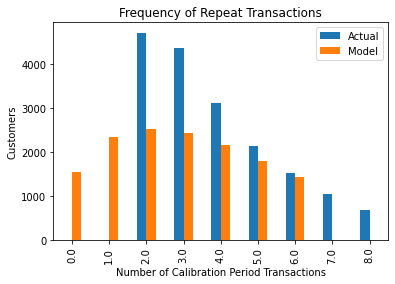

In [16]:
plot_period_transactions(bgf)
plt.show(block=True)

## Let's fit the Gamma-Gamma model


In [17]:
ggf = GammaGammaFitter(penalizer_coef=0.01).fit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])
ggf

<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 2.69, q: 0.14, v: 2.63>

### Let's estimate the average value of the customers and add it to the cltv dataframe as exp_average_value

In [18]:
cltv_df['exp_average_value'] = ggf.conditional_expected_average_profit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])
cltv_df

,recency_cltv_weekly,t_weekly,frequency,monetary_cltv_avg,expected_purc_3_month,expected_purc_6_month,exp_average_value
master_id,,,,,,,
00016786-2f5a-11ea-bb80-000d3a38a36f,78.571,80.000,5.000,29807.609,0.666,1.331,31844.828
00034aaa-a838-11e9-a2fc-000d3a38a36f,247.571,290.143,3.000,5968.538,0.218,0.437,6681.642
000be838-85df-11ea-a90b-000d3a38a36f,28.286,58.714,4.000,32637.767,0.682,1.364,35474.465
000c1fe2-a8b7-11ea-8479-000d3a38a36f,47.429,51.286,7.000,26026.033,1.004,2.008,27272.301
000f5e3e-9dde-11ea-80cd-000d3a38a36f,43.286,46.143,7.000,56582.656,1.046,2.092,59291.677
...,...,...,...,...,...,...,...
fff1db94-afd9-11ea-b736-000d3a38a36f,85.429,111.571,5.000,28940.929,0.554,1.107,30918.929
fff4736a-60a4-11ea-8dd8-000d3a38a36f,46.714,56.286,2.000,12673.166,0.513,1.026,15086.726
fffacd34-ae14-11e9-a2fc-000d3a38a36f,100.571,137.286,6.000,9236.320,0.543,1.086,9756.768


### Let's show the relationship between the monetary_cltv_avg and exp_average_value

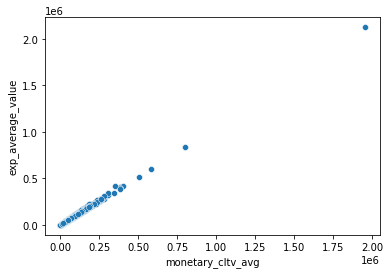

In [19]:
sns.scatterplot(x = cltv_df['monetary_cltv_avg'], y=cltv_df['exp_average_value'])
plt.show(block=True)

#### As you see, there is a high correlation between them.

### Let's calculate 6 months CLTV and add it to the dataframe with the name cltv

In [20]:
cltv_df['cltv'] = ggf.customer_lifetime_value(bgf, cltv_df['frequency'], cltv_df['recency_cltv_weekly'], cltv_df['t_weekly'], cltv_df['monetary_cltv_avg'], time=6, freq = 'W', discount_rate=0.01)
cltv_df

,recency_cltv_weekly,t_weekly,frequency,monetary_cltv_avg,expected_purc_3_month,expected_purc_6_month,exp_average_value,cltv
master_id,,,,,,,,
00016786-2f5a-11ea-bb80-000d3a38a36f,78.571,80.000,5.000,29807.609,0.666,1.331,31844.828,44483.731
00034aaa-a838-11e9-a2fc-000d3a38a36f,247.571,290.143,3.000,5968.538,0.218,0.437,6681.642,3060.568
000be838-85df-11ea-a90b-000d3a38a36f,28.286,58.714,4.000,32637.767,0.682,1.364,35474.465,50751.210
000c1fe2-a8b7-11ea-8479-000d3a38a36f,47.429,51.286,7.000,26026.033,1.004,2.008,27272.301,57455.075
000f5e3e-9dde-11ea-80cd-000d3a38a36f,43.286,46.143,7.000,56582.656,1.046,2.092,59291.677,130162.900
...,...,...,...,...,...,...,...,...
fff1db94-afd9-11ea-b736-000d3a38a36f,85.429,111.571,5.000,28940.929,0.554,1.107,30918.929,35927.364
fff4736a-60a4-11ea-8dd8-000d3a38a36f,46.714,56.286,2.000,12673.166,0.513,1.026,15086.726,16243.196
fffacd34-ae14-11e9-a2fc-000d3a38a36f,100.571,137.286,6.000,9236.320,0.543,1.086,9756.768,11122.478


### Let's observe the 20 people with the highest cltv value.

In [21]:
cltv_df.sort_values('cltv', ascending=False).head(20)

,recency_cltv_weekly,t_weekly,frequency,monetary_cltv_avg,expected_purc_3_month,expected_purc_6_month,exp_average_value,cltv
master_id,,,,,,,,
47a642fe-975b-11eb-8c2a-000d3a38a36f,2.857,7.857,4.000,1953336.000,1.094,2.189,2123067.301,4875638.233
53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.714,13.000,17.000,279081.006,2.781,5.561,284431.549,1659693.455
7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.143,13.143,11.000,382157.455,1.970,3.940,393600.144,1627207.452
8fd88976-6708-11ea-9d38-000d3a38a36f,50.286,63.286,7.000,802678.218,0.918,1.835,841103.043,1619494.620
9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.429,34.429,8.000,579323.466,1.265,2.531,603445.301,1602443.117
7e10b500-5b0b-11ea-9b03-000d3a38a36f,52.714,66.000,10.000,503008.176,1.153,2.307,519625.212,1257512.294
a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.714,67.286,52.000,126552.000,4.656,9.312,127335.122,1244147.144
e205f2ee-acdf-11e9-a2fc-000d3a38a36f,185.714,193.286,29.000,380969.876,1.455,2.909,385217.774,1175858.921
bdf7a804-b1dd-11e9-89fa-000d3a38a36f,90.571,97.429,18.000,342659.014,1.497,2.995,348856.870,1096226.895


# Let's create segments by CLTV

### Let's divide all customers into 4 groups (segments) according to 6-month CLTV and add the group names to the dataset.

In [22]:
cltv_df['segment'] = pd.qcut(cltv_df['cltv'], 4, labels=['D', 'C', 'B', 'A'])
cltv_df

,recency_cltv_weekly,t_weekly,frequency,monetary_cltv_avg,expected_purc_3_month,expected_purc_6_month,exp_average_value,cltv,segment
master_id,,,,,,,,,
00016786-2f5a-11ea-bb80-000d3a38a36f,78.571,80.000,5.000,29807.609,0.666,1.331,31844.828,44483.731,A
00034aaa-a838-11e9-a2fc-000d3a38a36f,247.571,290.143,3.000,5968.538,0.218,0.437,6681.642,3060.568,D
000be838-85df-11ea-a90b-000d3a38a36f,28.286,58.714,4.000,32637.767,0.682,1.364,35474.465,50751.210,A
000c1fe2-a8b7-11ea-8479-000d3a38a36f,47.429,51.286,7.000,26026.033,1.004,2.008,27272.301,57455.075,A
000f5e3e-9dde-11ea-80cd-000d3a38a36f,43.286,46.143,7.000,56582.656,1.046,2.092,59291.677,130162.900,A
...,...,...,...,...,...,...,...,...,...
fff1db94-afd9-11ea-b736-000d3a38a36f,85.429,111.571,5.000,28940.929,0.554,1.107,30918.929,35927.364,A
fff4736a-60a4-11ea-8dd8-000d3a38a36f,46.714,56.286,2.000,12673.166,0.513,1.026,15086.726,16243.196,B
fffacd34-ae14-11e9-a2fc-000d3a38a36f,100.571,137.286,6.000,9236.320,0.543,1.086,9756.768,11122.478,C


### Let's make short 6-month action suggestions to the management for 2 groups you will choose from among 4 groups.

In [23]:
def taking_action(dataframe, target, variable):
    print(dataframe.groupby(target).agg({variable: ['mean', 'count', 'sum']}))

num_cols = [col for col in cltv_df.columns if cltv_df[col].dtypes not in ['bool', 'category', 'object']]
for col in num_cols:
    print('--'*25)
    taking_action(cltv_df, 'segment', col)

--------------------------------------------------
        recency_cltv_weekly                 
                       mean count        sum
segment                                     
D                   112.018  4987 558632.714
C                    93.889  4986 468131.571
B                    88.418  4986 440852.000
A                    86.726  4986 432414.143
--------------------------------------------------
        t_weekly                 
            mean count        sum
segment                          
D        134.808  4987 672286.857
C        113.763  4986 567219.857
B        107.122  4986 534111.429
A        102.191  4986 509522.571
--------------------------------------------------
        frequency                
             mean count       sum
segment                          
D           3.419  4987 17049.000
C           4.211  4986 20998.000
B           5.026  4986 25060.000
A           7.257  4986 36182.000
--------------------------------------------------
     

# **Thank you for checking my notebook!**